### faissを使用した類似近傍検索による振動原因推定アルゴリズム　　
AWS JupyterLabでの動作環境：conda_tensorflow2_p38

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
#openpyxlのインポート
#エクセルファイル読み込みに必要
try:
    import openpyxl
except ModuleNotFoundError:
    %pip install openpyxl
    import openpyxl

In [3]:
#faissのインポート（少し時間かかる）
try:
    import faiss  # main package
except ModuleNotFoundError:
    %conda install -c pytorch faiss-cpu
    import faiss

In [4]:
#教師DBの読み込み
#status Normalが正常FFT、Abnormalが異常時FFT、Diffがその差分（異常時-正常）
df=pd.read_excel("teacher_xb2.xlsx", index_col=None, sheet_name="faiss_xb",header=0, parse_dates=["date"], engine="openpyxl")
df.dropna(subset=["no","machine"], how='all', inplace=True) #欠損行を削除
df

,no,machine,sensor_id,cat,status,results,AI _label,date,notes,8,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,1.0,BLOWER,VB389245,ACC,Normal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2019-04-07 10:18:53,demo(toyokohan),0.02,...,0.11,0.08,0.08,0.23,0.32,0.24,0.14,0.13,0.14,0.08
1,1.0,BLOWER,VB389245,ACC,Abnormal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2019-06-30 10:14:47,demo(toyokohan),0.03,...,0.54,0.35,0.06,0.21,0.24,0.23,0.12,0.19,0.11,0.14
2,1.0,BLOWER,VB389245,ACC,Diff,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,83.9971527777816,demo(toyokohan),0.01,...,0.43,0.27,-0.02,-0.02,-0.08,-0.01,-0.02,0.06,-0.03,0.06
3,2.0,ROLLER,VB60CAC6,ACC,Normal,Poor_lubrication,AITagLubric,2020-07-19 00:03:46,"No.11,toyokohan",0.01,...,0.02,0.00,0.04,0.00,0.04,0.01,0.03,0.05,0.07,0.14
4,2.0,ROLLER,VB60CAC6,ACC,Abnormal,Poor_lubrication,AITagLubric,2020-09-23 08:20:02,"No.11,toyokohan",0.00,...,0.05,0.03,0.01,0.01,0.03,0.05,0.05,0.05,0.03,0.04
5,2.0,ROLLER,VB60CAC6,ACC,Diff,Poor_lubrication,AITagLubric,66.34462962963153,"No.11,toyokohan",-0.01,...,0.03,0.03,-0.03,0.01,-0.01,0.04,0.02,0.00,-0.04,-0.10
6,3.0,MOTOR,VB3BD9D7,ACC,Normal,Poor_lubrication,AITagLubric,2020-09-28 19:21:32,"No.7,tokyosangyo",0.00,...,0.06,0.04,0.03,0.02,0.03,0.02,0.02,0.00,0.01,0.02
7,3.0,MOTOR,VB3BD9D7,ACC,Abnormal,Poor_lubrication,AITagLubric,2020-10-04 19:05:05,"No.7,tokyosangyo",0.00,...,0.01,0.00,0.03,0.01,0.02,0.03,0.03,0.01,0.00,0.00
8,3.0,MOTOR,VB3BD9D7,ACC,Diff,Poor_lubrication,AITagLubric,5.9885763888887595,"No.7,tokyosangyo",0.00,...,-0.05,-0.04,0.00,-0.01,-0.01,0.01,0.01,0.01,-0.01,-0.02
9,4.0,MOTOR,VB0F2036,ACC,Normal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2020-04-10 15:35:16,"No.9,Nitec",0.01,...,0.45,0.47,0.38,0.37,0.52,0.22,0.48,0.59,0.25,0.78


In [5]:
#データを正規化
#faissでコサイン類似度を使用する場合はそこで正規化するのでスキップする。
"""
#Min-Max正規化

def minmax_norm(df_input):
    return df_input.apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=1)

df_norm=minmax_norm(df.iloc[:,9:])
df_norm=pd.concat([df.iloc[:,:9],df_norm],axis=1)
df_norm
"""
df_norm=df.copy() #スキップの有無にかかわらず、変数名を同じにする。

In [6]:
#Diffの負値を０に置き換え
df_norm=pd.concat([df_norm.iloc[:,:9],df_norm.iloc[:,9:].clip(0,)],axis=1)

#移動平均による平滑化
acc_window=3 #ハイパラ

df_norm_mv=df_norm.iloc[:,9:].rolling(acc_window,axis=1,center=True).mean()
df_norm_mv.fillna(0,inplace=True)
df_norm_mv=pd.concat([df.iloc[:,:9],df_norm_mv],axis=1)
df_norm_mv

,no,machine,sensor_id,cat,status,results,AI _label,date,notes,8,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,1.0,BLOWER,VB389245,ACC,Normal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2019-04-07 10:18:53,demo(toyokohan),0.0,...,1.133333e-01,9.000000e-02,1.300000e-01,2.100000e-01,2.633333e-01,2.333333e-01,1.700000e-01,1.366667e-01,1.166667e-01,0.0
1,1.0,BLOWER,VB389245,ACC,Abnormal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2019-06-30 10:14:47,demo(toyokohan),0.0,...,3.666667e-01,3.166667e-01,2.066667e-01,1.700000e-01,2.266667e-01,1.966667e-01,1.800000e-01,1.400000e-01,1.466667e-01,0.0
2,1.0,BLOWER,VB389245,ACC,Diff,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,83.9971527777816,demo(toyokohan),0.0,...,2.533333e-01,2.333333e-01,9.000000e-02,7.401487e-17,7.401487e-17,7.401487e-17,2.000000e-02,2.000000e-02,4.000000e-02,0.0
3,2.0,ROLLER,VB60CAC6,ACC,Normal,Poor_lubrication,AITagLubric,2020-07-19 00:03:46,"No.11,toyokohan",0.0,...,3.000000e-02,2.000000e-02,1.333333e-02,2.666667e-02,1.666667e-02,2.666667e-02,3.000000e-02,5.000000e-02,8.666667e-02,0.0
4,2.0,ROLLER,VB60CAC6,ACC,Abnormal,Poor_lubrication,AITagLubric,2020-09-23 08:20:02,"No.11,toyokohan",0.0,...,4.333333e-02,3.000000e-02,1.666667e-02,1.666667e-02,3.000000e-02,4.333333e-02,5.000000e-02,4.333333e-02,4.000000e-02,0.0
5,2.0,ROLLER,VB60CAC6,ACC,Diff,Poor_lubrication,AITagLubric,66.34462962963153,"No.11,toyokohan",0.0,...,2.000000e-02,2.000000e-02,1.333333e-02,3.333333e-03,1.666667e-02,2.000000e-02,2.000000e-02,6.666667e-03,0.000000e+00,0.0
6,3.0,MOTOR,VB3BD9D7,ACC,Normal,Poor_lubrication,AITagLubric,2020-09-28 19:21:32,"No.7,tokyosangyo",0.0,...,7.333333e-02,4.333333e-02,3.000000e-02,2.666667e-02,2.333333e-02,2.333333e-02,1.333333e-02,1.000000e-02,1.000000e-02,0.0
7,3.0,MOTOR,VB3BD9D7,ACC,Abnormal,Poor_lubrication,AITagLubric,2020-10-04 19:05:05,"No.7,tokyosangyo",0.0,...,1.000000e-02,1.333333e-02,1.333333e-02,2.000000e-02,2.000000e-02,2.666667e-02,2.333333e-02,1.333333e-02,3.333333e-03,0.0
8,3.0,MOTOR,VB3BD9D7,ACC,Diff,Poor_lubrication,AITagLubric,5.9885763888887595,"No.7,tokyosangyo",0.0,...,7.401487e-17,7.401487e-17,7.401487e-17,7.401487e-17,3.333333e-03,6.666667e-03,1.000000e-02,6.666667e-03,3.333333e-03,0.0
9,4.0,MOTOR,VB0F2036,ACC,Normal,"Poor_lubrication, Metal_rubbing",AITagLubric&AITagContact,2020-04-10 15:35:16,"No.9,Nitec",0.0,...,5.333333e-01,4.333333e-01,4.066667e-01,4.233333e-01,3.700000e-01,4.066667e-01,4.300000e-01,4.400000e-01,5.400000e-01,0.0


In [7]:
#Max poolingする場合
"""
pool_window=3
df_norm_maxpool=df_norm.iloc[:,9:].rolling(pool_window,axis=1).max().dropna(axis=1).T[::3].clip(0,) #負の値を0に置き換え

df_norm_maxpool=pd.concat([df.iloc[:,:9],df_norm_maxpool.T],axis=1)

#FFT表示
fig=plt.figure(figsize=(15, n_of_fft*3))

#正常FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+1)
    plt.title(df_norm_maxpool[df_norm_maxpool["status"]=="Normal"].iloc[i,4])
    plt.plot(df_norm_maxpool.columns[9:], df_norm_maxpool[df_norm_maxpool["status"]=="Normal"].T.iloc[9:,i],
             alpha=1.0, color="blue", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_maxpool.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')

#異常FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+2)
    plt.title(df_norm_maxpool[df_norm_maxpool["status"]=="Abnormal"].iloc[i,5])
    plt.plot(df_norm_maxpool.columns[9:], df_norm_maxpool[df_norm_maxpool["status"]=="Abnormal"].T.iloc[9:,i],
             alpha=1.0, color="red", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_maxpool.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')

#差分FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+3)
    plt.title(df_norm_maxpool[df_norm_maxpool["status"]=="Diff"].iloc[i,4])
    plt.plot(df_norm_maxpool.columns[9:], df_norm_maxpool[df_norm_maxpool["status"]=="Diff"].T.iloc[9:,i],
             alpha=1.0, color="green", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_maxpool.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')


plt.tight_layout() 
plt.show()
fig.savefig("xb(maxpool).png")
"""

'\npool_window=3\ndf_norm_maxpool=df_norm.iloc[:,9:].rolling(pool_window,axis=1).max().dropna(axis=1).T[::3].clip(0,) #負の値を0に置き換え\n\ndf_norm_maxpool=pd.concat([df.iloc[:,:9],df_norm_maxpool.T],axis=1)\n\n#FFT表示\nfig=plt.figure(figsize=(15, n_of_fft*3))\n\n#正常FFT\nfor i in range (n_of_fft):\n    plt.subplot(n_of_fft,3,3*i+1)\n    plt.title(df_norm_maxpool[df_norm_maxpool["status"]=="Normal"].iloc[i,4])\n    plt.plot(df_norm_maxpool.columns[9:], df_norm_maxpool[df_norm_maxpool["status"]=="Normal"].T.iloc[9:,i],\n             alpha=1.0, color="blue", label=None, linestyle="-", linewidth=1.0, marker=None)\n    plt.ylim([0,df_norm_maxpool.iloc[i*3:i*3+3,9:].max().max()])\n    plt.xlabel(\'Hz\')\n    plt.ylabel(\'ACC\')\n\n#異常FFT\nfor i in range (n_of_fft):\n    plt.subplot(n_of_fft,3,3*i+2)\n    plt.title(df_norm_maxpool[df_norm_maxpool["status"]=="Abnormal"].iloc[i,5])\n    plt.plot(df_norm_maxpool.columns[9:], df_norm_maxpool[df_norm_maxpool["status"]=="Abnormal"].T.iloc[9:,i],\n         

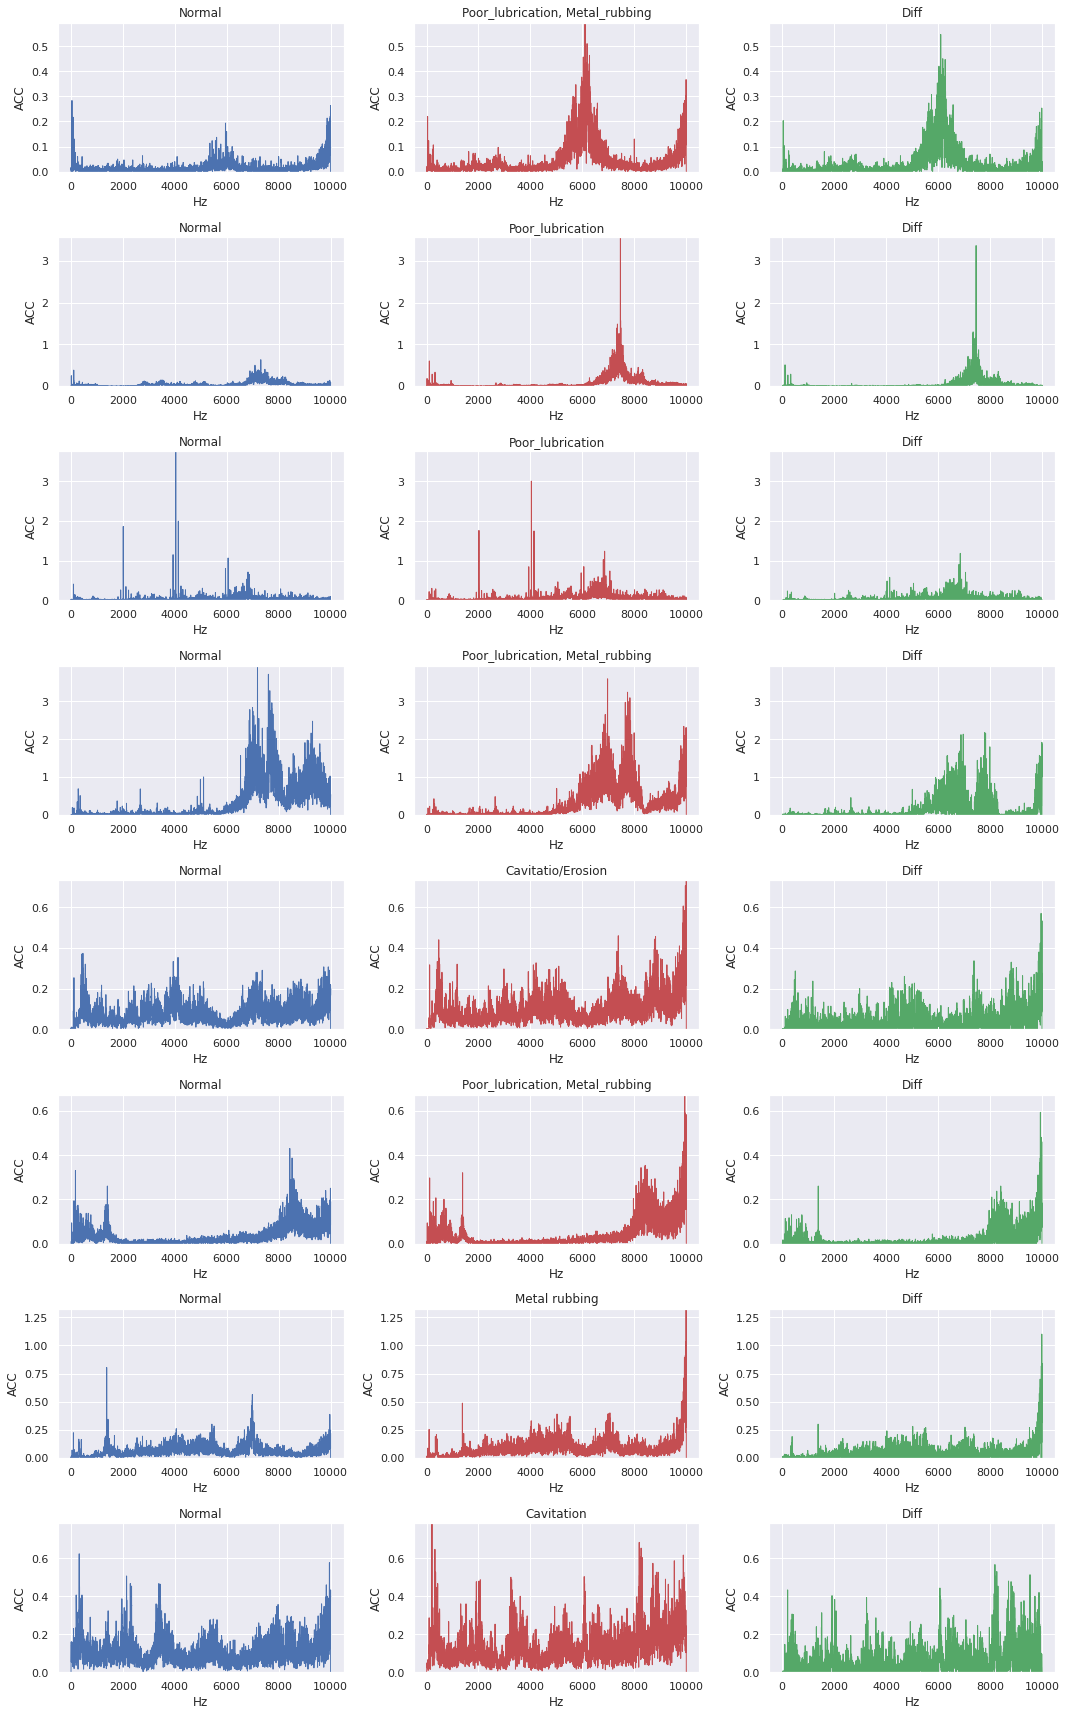

In [8]:
#教師FFTの表示
n_of_fft=len(df_norm)//3

fig=plt.figure(figsize=(15, n_of_fft*3))

#正常FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+1)
    plt.title(df_norm_mv[df_norm_mv["status"]=="Normal"].iloc[i,4])
    plt.plot(np.arange(8,10001), df_norm_mv[df_norm_mv["status"]=="Normal"].T.iloc[9:,i], alpha=1.0, color="b", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_mv.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')

#異常FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+2)
    plt.title(df_norm_mv[df_norm_mv["status"]=="Abnormal"].iloc[i,5])
    plt.plot(np.arange(8,10001), df_norm_mv[df_norm_mv["status"]=="Abnormal"].T.iloc[9:,i], alpha=1.0, color="r", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_mv.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')

#差分FFT
for i in range (n_of_fft):
    plt.subplot(n_of_fft,3,3*i+3)
    plt.title(df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[i,4])
    plt.plot(np.arange(8,10001), df_norm_mv[df_norm_mv["status"]=="Diff"].T.iloc[9:,i], alpha=1.0, color="g", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,df_norm_mv.iloc[i*3:i*3+3,9:].max().max()])
    plt.xlabel('Hz')
    plt.ylabel('ACC')

plt.tight_layout() 
plt.show()

fig.savefig("xb(mv).png")

In [9]:
#クエリFFT（判定したいFFT）の読み込み
#正常と異常を読み込み、差分をとる（差分FFT）
#差分FFTのマイナス値は0にする。
#差分FFTをacc_windowで平滑化してクエリとする。
#対象は加速度FFTのみ。

df_query=pd.read_excel("query.xlsx", index_col=0, engine="openpyxl")
#df_query=pd.concat([df_query,df_query["abnormal"]-df_query["normal"].clip(0,)],axis=1) #差分を計算　負の値は０にする
df_query["diff"]=df_query["abnormal"]-df_query["normal"].clip(0,) #差分を計算　負の値は０にする

#移動平均
df_query_mv=df_query.rolling(acc_window,axis=0,center=True).mean()
df_query_mv.fillna(0,inplace=True)
df_query_mv

,normal,abnormal,diff
Hz-m/s2,,,
8,0.000000,0.000000,0.000000
9,0.006667,4.276667,4.270000
10,0.006667,4.446667,4.440000
11,0.003333,5.120000,5.116667
12,0.000000,4.956667,4.956667
...,...,...,...
9996,0.456667,7.643333,7.186667
9997,0.413333,10.580000,10.166667
9998,0.536667,9.380000,8.843333


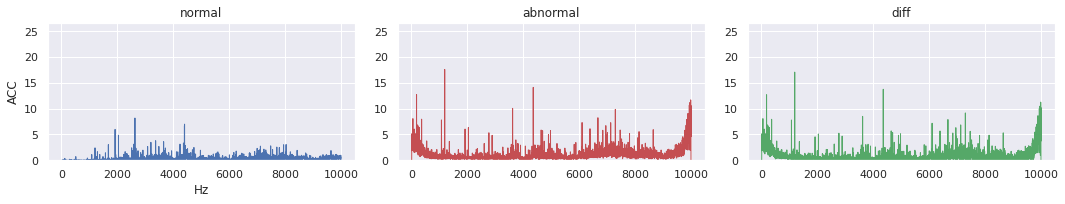

In [10]:
#クエリFFTの表示
plt.figure(figsize=(15,3))
           
plt.subplot(1,3,1)
plt.title("normal")
plt.plot(df_query_mv["normal"], alpha=1.0, color="b", label=None, linestyle="-", linewidth=1.0, marker=None)
plt.ylim([0,df_query.max().max()])
plt.xlabel('Hz')
plt.ylabel('ACC')
           
plt.subplot(1,3,2)
plt.title("abnormal")
plt.plot(df_query_mv["abnormal"], alpha=1.0, color="r", label=None, linestyle="-", linewidth=1.0, marker=None)
plt.ylim([0,df_query.max().max()])
           
plt.subplot(1,3,3)
plt.title("diff")
plt.plot(df_query_mv["diff"], alpha=1.0, color="g", label=None, linestyle="-", linewidth=1.0, marker=None)
plt.ylim([0,df_query.max().max()])
           
plt.tight_layout() 
plt.show()
fig.savefig("df_query_mv.png")

In [11]:
#クエリを作成
xq=df_query_mv["diff"].values.copy(order='C').reshape(1,9993).astype("float32")
#print(xq.flags)

In [12]:
d=9993 #加速度FFTの次元
index=faiss.index_factory(d, "Flat", faiss.METRIC_INNER_PRODUCT) #インデックスの作成 INNER_PRODUCT
#print(index.is_trained) #indexの学習がされたかどうか

#教師DB
xb=df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[:,9:].values.copy(order='C').astype(np.float32)
faiss.normalize_L2(xb) #cosine similarityの時必要
index.add(xb)
#print(index.ntotal)
faiss.normalize_L2(xq) #cosine similarityの時必要


In [13]:
#次元数が4の倍数かつ同時検索クエリ数が20件以下の場合はSSEを使って距離計算,
#それ以上ではBLAS実装に計算処理が委譲される。マルチスレッドで処理される箇所はOpenMPを使って実装されている

#上位何位まで検索するか？
k=3

#クエリFFTでk-近傍探索
D,I=index.search(xq,k) # actual search

print("k近傍インデックス:{}".format(I))
print("近傍距離:{}".format(D))


k近傍インデックス:[[6 5 4]]
近傍距離:[[0.52974486 0.5066507  0.48327246]]


In [14]:
df_results=pd.concat(
    [pd.DataFrame(I,columns=["I_1st","I_2nd","I_3rd"]),
     pd.DataFrame(D,columns=["D_1st","D_2nd","D_3rd"])],
    axis=1)
df_results

,I_1st,I_2nd,I_3rd,D_1st,D_2nd,D_3rd
0,6,5,4,0.529745,0.506651,0.483272


In [15]:
#Dist(距離)以上のみを抽出
Dist=0.5 #ハイパラ

df_results_pick=df_results[df_results["D_1st"]>Dist]
df_results_pick

,I_1st,I_2nd,I_3rd,D_1st,D_2nd,D_3rd
0,6,5,4,0.529745,0.506651,0.483272


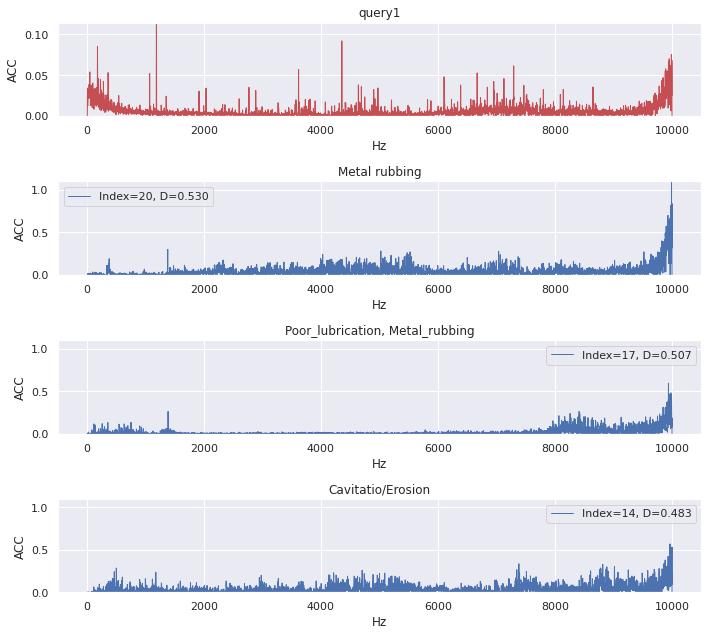

In [16]:
#クエリと原因
fig=plt.figure(figsize=(10, k*3))

#加速度FFT

for i in range (len(xq)):
    plt.subplot(k+1,len(xq),i+1)
    plt.plot(np.arange(8,10001),xq[i], alpha=1.0, color="r", label=None, linestyle="-", linewidth=1.0, marker=None)
    plt.ylim([0,xq.max().max()])
    plt.title("query"+str(i+1))
    plt.xlabel('Hz')
    plt.ylabel('ACC')
    
    for j in range (k):
        plt.subplot(k+1,len(xq),len(xq)+(i+1)*(j+1))
        plt.plot(np.arange(8,10001), df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i][j],9:], alpha=1.0, color="b",
                 label=f"Index={df_norm_mv[df_norm_mv['status']=='Diff'].index[I[i][j]]}, D={D[i][j]:.3f}", linestyle="-", linewidth=1.0, marker=None)
        plt.title(df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i][j],5])
        plt.ylim([0,df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i],9:].max().max()])
        plt.xlabel('Hz')
        plt.ylabel('ACC')
        plt.legend()
    plt.tight_layout() 

fig.savefig("result(xq+xb).png")

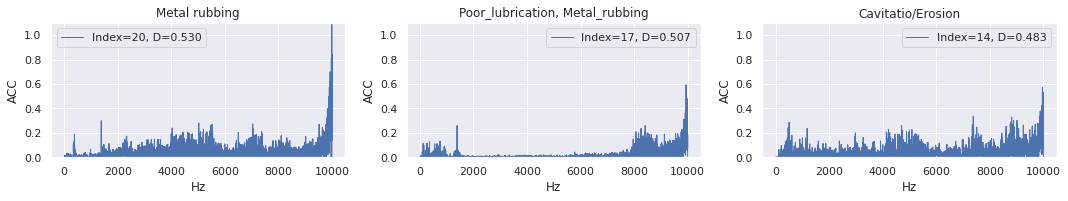

In [17]:
#原因のみ
fig=plt.figure(figsize=(k*5, len(xq)*5))

for i in range (len(xq)):
    
    for j in range (k):
        plt.subplot(len(xq)+1,k,(i*3)+(j+1))
        plt.plot(np.arange(8,10001), df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i][j],9:], alpha=1.0, color="b",
                 label=f"Index={df_norm_mv[df_norm_mv['status']=='Diff'].index[I[i][j]]}, D={D[i][j]:.3f}", linestyle="-", linewidth=1.0, marker=None)
        plt.title(df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i][j],5])
        plt.ylim([0,df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[i],9:].max().max()])
        plt.xlabel('Hz')
        plt.ylabel('ACC')
        plt.legend()
    plt.tight_layout() 

plt.tight_layout() 
plt.show() 
fig.savefig("result(xb).png")

In [19]:
#推定原因
df_norm_mv[df_norm_mv["status"]=="Diff"].iloc[I[0][0],5]
print(f"推定原因 : {df_norm_mv[df_norm_mv['status']=='Diff'].iloc[I[0][0],5]}")
print(f"AI_label : {df_norm_mv[df_norm_mv['status']=='Diff'].iloc[I[0][0],6]}")
print(f"D={D[0][0]:.3f}")

推定原因 : Metal rubbing
AI_label : AITagContact
D=0.530
